**Table of contents**<a id='toc0_'></a>    
- [Libraries](#toc1_1_)    
- [EDA](#toc2_)    
    - [Basic analysis](#toc2_1_1_)    
    - [Preparation column](#toc2_1_2_)    
      - [Data cleaning](#toc2_1_2_1_)    
    - [Ingredients column](#toc2_1_3_)    
      - [Data cleaning](#toc2_1_3_1_)    
      - [Exploratary Analysis](#toc2_1_3_2_)    
    - [Title column](#toc2_1_4_)    
      - [Data cleaning](#toc2_1_4_1_)    
      - [Exploratary analysis](#toc2_1_4_2_)    
- [Modeling](#toc3_)    
    - [Word2vec](#toc3_1_1_)    
      - [Mean Embedding Vector](#toc3_1_1_1_)    
      - [TFIDF Embedding Vectoriser](#toc3_1_1_2_)    
    - [Recommendations](#toc3_1_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Libraries](#toc0_)


In [2]:
#importing the basic libraries
import numpy as np
import pandas as pd

#visualisation libraries 
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [3]:
#importing the word processing libraries 


 #importing the regex library
import re

#importing the nltk library
import nltk
nltk.download()

#lemmatizer
from nltk.stem import WordNetLemmatizer 
import spacy

# loading the spaCy English language model
nlp = spacy.load("en_core_web_sm")

#  nltk stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

#defining the stop words
ENGLISH_STOP_WORDS = stopwords.words('english')

#library to handle punctuation
import string

#counter library
from collections import Counter 

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anupajayakody/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
#speech tagging library 
from nltk import pos_tag

#library for word embedding 
from gensim.models import Word2Vec, Phrases
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from collections import defaultdict 
from sklearn.metrics.pairwise import cosine_similarity

# <a id='toc2_'></a>[EDA](#toc0_)

### <a id='toc2_1_1_'></a>[Basic analysis](#toc0_)

In [5]:
#reading data
recipes= pd.read_csv('/Users/anupajayakody/Documents/BOOTCAMP/CAPSTONE/DATA/RECIPES/vegan_recipes.csv')

In [6]:
#checking a sample of data
recipes.head()

,Unnamed: 0,href,title,ingredients,preparation
0,0,https://veganuary.com/recipes/rainbow-rice/,Rainbow Rice,\nIngredients\n\nCarrot ribbons (just use a pe...,\nMethod\n\nCook the rice as instructed on the...
1,1,https://veganuary.com/recipes/mfc-nachos/,Nachos,\nIngredients\n\n400g Meatless Farm Co mince (...,\nPreparation\n\nPreheat the oven to 350ºF\nHe...
2,2,https://veganuary.com/recipes/hazelnut-truffles/,Hazelnut Truffles,\nIngredients\n\n100g hazelnuts\n2 tablespoons...,\nMethod\n\nPreheat the oven to 200c\nPut the ...
3,3,https://veganuary.com/recipes/simple-roasted-r...,Simple Roasted Radish by ChicP,\nIngredients\n\n1 170g tub beetroot and horse...,\nPreparation\nPre heat the oven to 160°C\nCut...
4,4,https://veganuary.com/recipes/baked-apple-char...,Baked Apple Charlotte,\nIngredients\n\n2 tbsp rapeseed oil\n75g pitt...,\nPreparation\n\nServes 9\nYou will need an 8i...


It can be seen that data entails the recipe URL, recipe title, ingredients and the preparation method. This is good for any consumer of this solution.

In [7]:
#getting column info
recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1390 entries, 0 to 1389
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   1390 non-null   int64 
 1   href         1390 non-null   object
 2   title        1390 non-null   object
 3   ingredients  1390 non-null   object
 4   preparation  1390 non-null   object
dtypes: int64(1), object(4)
memory usage: 54.4+ KB


In [8]:
#getting data stats
recipes.describe()

,Unnamed: 0
count,1390.000000
mean,694.500000
std,401.402749
min,0.000000
25%,347.250000
50%,694.500000
75%,1041.750000
max,1389.000000


Since all columns are string type, we do not get any numerical statistics here.

It can be seen that all columns are stored as strings and this is good for the further processing of the data.

I will now check whether there are any duplicates in data. First will check the total unique values to see if any duplicate data.

In [9]:
#getting the count of unique recipes 
recipes['title'].unique().shape

(1373,)

It can be seen that there are duplicate values in the dataframes as the total rows are 1390 and unique rows are only 1373. I will print the duplicates for each column to analyse whether we can remove any data.

In [10]:
print('no.of title duplicates', recipes['title'].duplicated().sum())
print('no.of ingredients duplicates', recipes['ingredients'].duplicated().sum())
print('no.of preparation duplicates', recipes['preparation'].duplicated().sum())

no.of title duplicates 17
no.of ingredients duplicates 8
no.of preparation duplicates 9


We will further analyse on the duplicate contents.

In [11]:
#getting the duplicates of titles 
title_duplicates= recipes[recipes['title'].duplicated(keep= False)]
title_duplicates

,Unnamed: 0,href,title,ingredients,preparation
26,26,https://veganuary.com/recipes/superfood-salad/,Superfood Salad,\nIngredients\n\n200g (1 cup + 2 Tbsp) white q...,\nMethod\n\nIn a saucepan boil the quinoa in s...
41,41,https://veganuary.com/recipes/chilli-non-carne...,Chilli Non Carne,\nIngredients\n\n2-3 tbsp olive oil\n400g Meat...,\nPreparation\n\nPlace a large non-stick sauce...
69,69,https://veganuary.com/recipes/spanish-omelette/,Spanish Omelette,\nIngredients\n\n2 potatoes\n1 onion\n4 tbsp c...,"\nPreparation\n\nSlice the onion and potatoes,..."
178,178,https://veganuary.com/recipes/vegan-butter-chi...,Vegan Butter Chicken,\nIngredients\nFor the marinade:\n100ml Elmlea...,"\nPreparation\n1. To prepare the marinade, add..."
180,180,https://veganuary.com/recipes/superfood-salad-...,Superfood Salad,\nIngredients\n\n45ml PizzaExpress Vegan House...,\nPreparation\n\nMix the superfood ingredients...
208,208,https://veganuary.com/recipes/tofu-scramble-2/,Tofu Scramble,\nIngredients\n\n350g silken firm tofu\n1 tsp ...,\nMethod\n\nHeat the oil on a moderate heat in...
256,256,https://veganuary.com/recipes/meatless-farm-ve...,Vegan Butter Chicken,\nIngredients\n4 Meatless Farm Chicken Breasts...,\nMethod\n1. Pre-heat your oven to 180.C\n2. M...
294,294,https://veganuary.com/recipes/vegetable-curry/,Vegetable Curry,\nIngredients\n\n• 300g Provamel soya alternat...,\nPreparation\nServes 4.\nReplace the chickpea...
308,308,https://veganuary.com/recipes/tofu-scramble/,Tofu Scramble,\nIngredients\n\n1 tablespoon toasted sesame o...,\nMethod\nHeat the oil in a heavy frying pan o...
388,388,https://veganuary.com/recipes/tortilla-espanol...,Spanish Omelette,"\nIngredients\n\n1kg (2 lb.) potatoes, sliced\...",\nMethod\n\n\n\nShallow fry the onions and pot...


In [12]:
#getting the duplicates of ingredients 
ingredients_duplicates= recipes[recipes['ingredients'].duplicated(keep= False)]
ingredients_duplicates

,Unnamed: 0,href,title,ingredients,preparation
881,881,https://simple-veganista.com/raw-pad-thai_18/,RAW PAD THAI,\n\n\nIngredients\n\n\n\nScale\n1x2x3x \n\n\n\...,\n\nInstructions\n\n\nSauce: In a small/medium...
889,889,https://simple-veganista.com/savory-chickpea-p...,SAVORY CHICKPEA PANCAKE (GF),\n\n\nIngredients\n\n\n\nScale\n1x2x3x \n\n\n\...,\n\nInstructions\n\n\nPreheat griddle on mediu...
927,927,https://simple-veganista.com/sweet-tang-chia-s...,Chia Seed Smoothie,\n\n\nIngredients\n\n\n\nUnits\nUSM \n\nScale\...,"\n\nInstructions\n\n\nPlace the frozen fruit, ..."
955,955,https://simple-veganista.com/raw-creamy-miso-s...,RAW CREAMY MISO SOUP WITH MUSHROOMS,\n\n\nIngredients\n\n\n\nScale\n1x2x3x \n\n\n\...,\n\nInstructions\n\n\nMushrooms: Start with th...
977,977,https://simple-veganista.com/raw-creamy-miso-s...,RAW CREAMY MISO SOUP WITH MUSHROOMS,\n\n\nIngredients\n\n\n\nScale\n1x2x3x \n\n\n\...,\n\nInstructions\n\n\nMushrooms: Start with th...
1007,1007,https://simple-veganista.com/savory-chickpea-p...,SAVORY CHICKPEA PANCAKE (GF),\n\n\nIngredients\n\n\n\nScale\n1x2x3x \n\n\n\...,\n\nInstructions\n\n\nPreheat griddle on mediu...
1047,1047,https://simple-veganista.com/orange-french-toas/,ORANGE FRENCH TOAST (VEGAN),\n\n\nIngredients\n\n\n\nScale\n1x2x3x \n\n\n\...,\n\nInstructions\n\n\nPreheat a griddle accord...
1069,1069,https://simple-veganista.com/orange-french-toa...,ORANGE FRENCH TOAST (VEGAN),\n\n\nIngredients\n\n\n\nScale\n1x2x3x \n\n\n\...,\n\nInstructions\n\n\nPreheat a griddle accord...
1172,1172,https://simple-veganista.com/plum-pineapple-ch...,Chia Seed Smoothie,\n\n\nIngredients\n\n\n\nUnits\nUSM \n\nScale\...,"\n\nInstructions\n\n\nPlace the frozen fruit, ..."
1252,1252,https://simple-veganista.com/avocados-are-so-v...,Stuffed Avocados,\n\n\nIngredients\n\n\n\nScale\n1x2x3x \n\n\n\...,\n\nInstructions\n\n\nPrepare the ingredients....


It is visible that the ingredient duplicates are indeed recipe duplicates where as title duplicates are different recipes eventhough they have the same titles. Therefore we will drop the ingredients duplicates only; 9 rows 

In [13]:
recipes= recipes.drop_duplicates(['ingredients']) #dropping the ingredient duplicates
recipes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1382 entries, 0 to 1389
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   1382 non-null   int64 
 1   href         1382 non-null   object
 2   title        1382 non-null   object
 3   ingredients  1382 non-null   object
 4   preparation  1382 non-null   object
dtypes: int64(1), object(4)
memory usage: 64.8+ KB


All the columns are stored as strings and have no null values 

### <a id='toc2_1_2_'></a>[Preparation column](#toc0_)

#### <a id='toc2_1_2_1_'></a>[Data cleaning](#toc0_)

There are words such as 'instructions' at every recipe. Therefore I will first remove them to achive a clean state for the reader and I will be using regex to replace such patterns.

In [14]:
#cleaned preparation list
recipes['preparation']

0       \nMethod\n\nCook the rice as instructed on the...
1       \nPreparation\n\nPreheat the oven to 350ºF\nHe...
2       \nMethod\n\nPreheat the oven to 200c\nPut the ...
3       \nPreparation\nPre heat the oven to 160°C\nCut...
4       \nPreparation\n\nServes 9\nYou will need an 8i...
                              ...                        
1385    \n\nInstructions\n\n\nSaute: In a large pot, h...
1386    \n\nInstructions\n\n\nPreheat oven to 350 degr...
1387    \n\nInstructions\n\n\nPreheat oven to 350 degr...
1388    \n\nInstructions\n\n\nDIY tortilla strips: Pre...
1389    \n\nInstructions\n\n\nPasta: Cook the noodles ...
Name: preparation, Length: 1382, dtype: object

In [15]:
#replacing every new line '\n' with a ','

preparation= recipes['preparation'] #creating a new variable for preparation
prep_pattern = re.compile(r'\n+') # creating a regex pattern for the \n

for i in range(len(preparation)):
    preparation.iloc[i]= prep_pattern.sub(',', preparation.iloc[i]) #replacing the values with a for loop

preparation

/var/folders/0y/k2wtvzs527g8z6726scfz6_80000gn/T/ipykernel_1132/3660587263.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preparation.iloc[i]= prep_pattern.sub(',', preparation.iloc[i]) #replacing the values with a for loop


0       ,Method,Cook the rice as instructed on the pac...
1       ,Preparation,Preheat the oven to 350ºF,Heat th...
2       ,Method,Preheat the oven to 200c,Put the hazel...
3       ,Preparation,Pre heat the oven to 160°C,Cut th...
4       ,Preparation,Serves 9,You will need an 8inch/2...
                              ...                        
1385    ,Instructions,Saute: In a large pot, heat oil ...
1386    ,Instructions,Preheat oven to 350 degrees F. L...
1387    ,Instructions,Preheat oven to 350 degrees.,Pas...
1388    ,Instructions,DIY tortilla strips: Preheat ove...
1389    ,Instructions,Pasta: Cook the noodles accordin...
Name: preparation, Length: 1382, dtype: object

In [16]:
#removing the ',Method' & the  ',Preparation' strings which appaear in the preparation column 
#removing them to avoid those words being picked up for the similarity matrix and to have a consistency

prep_method_pattern= re.compile(r',Method,') # creating a regex pattern 
prep_prep_pattern= re.compile(r',Preparation,') # creating a regex pattern 

for i in range(len(preparation)):
    preparation.iloc[i]= prep_method_pattern.sub('',preparation.iloc[i])
    preparation.iloc[i]= prep_prep_pattern.sub('',preparation.iloc[i]) #replacing the values with a for loop

preparation[1]

/var/folders/0y/k2wtvzs527g8z6726scfz6_80000gn/T/ipykernel_1132/3699458349.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preparation.iloc[i]= prep_method_pattern.sub('',preparation.iloc[i])
/var/folders/0y/k2wtvzs527g8z6726scfz6_80000gn/T/ipykernel_1132/3699458349.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preparation.iloc[i]= prep_prep_pattern.sub('',preparation.iloc[i]) #replacing the values with a for loop


'Preheat the oven to 350ºF,Heat the oil in a large, deep pan on medium heat. Cook the Meatless Farm mince (or similar) until lightly browned.,Add the refried beans, chopped tomatoes, tomato puree, chopped bell peppers, onion and the taco seasoning mix to the pot. Simmer and reduce for 10 – 12 minutes.,While the mince\xa0mixture is simmering, arrange the tortilla\xa0chips\xa0in a shallow casserole dish.,Next spoon the hot\xa0mince\xa0mixture over the chips.,Sprinkle the shredded cheese on top and transfer to the preheated oven.,Bake the nachos for 20 minutes, or until the cheese has melted and is lightly browned.,Serve the nachos hot from the oven along with a cashew sour cream and guacamole, as desired.,'

### <a id='toc2_1_3_'></a>[Ingredients column](#toc0_)

#### <a id='toc2_1_3_1_'></a>[Data cleaning](#toc0_)

In [17]:
#checking the data

ingredients= recipes['ingredients'] #creating a new variable for ingredients data
ingredients.head()

0    \nIngredients\n\nCarrot ribbons (just use a pe...
1    \nIngredients\n\n400g Meatless Farm Co mince (...
2    \nIngredients\n\n100g hazelnuts\n2 tablespoons...
3    \nIngredients\n\n1 170g tub beetroot and horse...
4    \nIngredients\n\n2 tbsp rapeseed oil\n75g pitt...
Name: ingredients, dtype: object

Similarly, there are patterns, new lines in the ingredient lists too. Therefore they will be removed using regex. In ingredients, removing them is important because this is the column from which the similarity will be mapped, hence having words that are not true ingredients could skew the results. 

In [18]:
#replacing every new line '\n' with a ','

new_line_pattern = re.compile(r'\n+') # creating a regex pattern for the \n

for i in range(len(ingredients)):
    ingredients.iloc[i]= new_line_pattern.sub(',', ingredients.iloc[i]) #replacing the values with a for loop

ingredients

/var/folders/0y/k2wtvzs527g8z6726scfz6_80000gn/T/ipykernel_1132/567534489.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ingredients.iloc[i]= new_line_pattern.sub(',', ingredients.iloc[i]) #replacing the values with a for loop


0       ,Ingredients,Carrot ribbons (just use a peeler...
1       ,Ingredients,400g Meatless Farm Co mince (or s...
2       ,Ingredients,100g hazelnuts,2 tablespoons + 1 ...
3       ,Ingredients,1 170g tub beetroot and horseradi...
4       ,Ingredients,2 tbsp rapeseed oil,75g pitted da...
                              ...                        
1385    ,Ingredients,Units,USM ,Scale,1x2x3x ,1 tables...
1386    ,Ingredients,Scale,1x2x3x ,2 tablespoons flaxs...
1387    ,Ingredients,Scale,1x2x3x ,16 oz. package past...
1388    ,Ingredients,Units,USM ,Scale,1x2x3x ,5 – 6 cu...
1389    ,Ingredients,Units,USM ,Scale,1x2x3x ,4 – 5 ta...
Name: ingredients, Length: 1382, dtype: object

In [19]:
#replacing the ',Ingredients,' pattern which is at the begining of every ingredient list with an empty string''
#removing them to avoid those words being picked up for the similarity matrix and to have a consistency

ing_pattern= re.compile(r',Ingredients,')

for i in range(len(ingredients)):
    ingredients.iloc[i]= ing_pattern.sub('',ingredients.iloc[i])

ingredients[0]

/var/folders/0y/k2wtvzs527g8z6726scfz6_80000gn/T/ipykernel_1132/4244282613.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ingredients.iloc[i]= ing_pattern.sub('',ingredients.iloc[i])


'Carrot ribbons (just use a peeler for speed),Frozen peas,Red cabbage,Yellow peppers,Red onion,1 tsp miso paste,1 tsp of Chinese five spice,2 tbsp of soy sauce,1 tbsp of oil,100g white rice,'

As the next step, I will be refining the ingredients data to avoid biases from different words and to have more consistency for comparsion of the input data vs the recipe data in the database 

In Sprint 1, I followed a process where I had multiple lines of codes for each data cleaning step, here I am creating one parser function which can be used to clean both ingredients and title columns. Furthermore in Sprint 1, my ingredients were cleaned in a way that an example of 'red cabbage' would produce 2 tokens red and cabbage seperately, but in the project context, these words should remain in the original form as red cabbage to make sense. So I have changed my cleaning steps to incorporate that. Further more, I also have added an additional steps of identifying verbs and removing them using parts of speech tagging method in NLP to filter true ingredients as much as possible. 

As the recipes will usually contain alot of measuring terms and this will repeat, I will remove them from the list for the cleaning purpose to remove the biases from them.

In [20]:
#defining measuring units

measurment_url= 'https://en.wikibooks.org/wiki/Cookbook:Units_of_measurement' #data source


measuring_words= ['ml', 'mL', 'milliliter', 'millilitre', 'cc' , 'cubic centimeter', 'l', 'L', 'liter', 'litre', 'dl', 'dL', 'deciliter', 'decilitre', 'teaspoon', 't' , 'tsp.', 
'tablespoon' , 'T', 'tbl', 'tbs', 'tbsp', 'fluid ounce', 'fl oz',  'gill', 'cup',  'c', 'pint', 'p', 'pt', 'fl pt', 
'quart', 'q', 'qt', 'fl qt', 'gallon' , 'g' , 'gal' , 'g', 'milligram', 'milligramme', 'g' , 'gram' , 'gramme', 'kg', 
'kilogram', 'kilogramme', 'pound', 'lb', 'ounce', 'oz', 'mm', 'millimeter', 'millimetre', 'cm' , 'centimeter', 'centimetre', 'm' , 'meter', 
'metre', 'inch', 'in', 'yard', '°C' , 'degree celsius','°F' ,'Farenheit', 'tsp']

Next I will 
- break each ingredient list to tokens/words
- lower case
- remove stop words
- remove verbs
- remove measuring word
- remove characters and numbers

All this is done to remove any impact from those words/tokens to the tool as the recommendation engine should only map for the true ingredients. 

In [21]:
def parser(input_keys): #function 
    
    ingredients_list = re.split(',', input_keys) #splitting the ingredients by commas 
    
    cleaned_ingredients = [] #new list to store cleaned ingredients 

    lemmatizer = WordNetLemmatizer() #lemmatizer 

    for ingredient in ingredients_list:
        items = re.split(' ', ingredient)  #splitting each ingredient by space to process and clean each individual word

        items = [word for word in items if word.isalpha()] #filtering only letters 

        tagged_items= pos_tag(items) #tagging the words to identify verbs 

        items= [word for word, pos in tagged_items if not pos.startswith('VB')] #filtering to remove any word which is a verb

        items = [word.lower() for word in items] #lowercasing 

        items = [lemmatizer.lemmatize(word) for word in items] #lemmatizing 

        items = [word for word in items if word not in ENGLISH_STOP_WORDS] #removing stop words

        items = [word for word in items if word not in measuring_words] #removing measuring words 

        if items:
            cleaned_ingredients.append(' '.join(items) ) #joining the individual words of the ingredient seperated by space 
    cleaned_ingredients= ','.join(cleaned_ingredients) #joining the ingreidents back seprated by commas 


    return cleaned_ingredients #return the list


In [22]:
#storing all cleaned ingreidents with the parser 
ingredients_cleaned = ingredients.apply(parser)

In [23]:
ingredients_cleaned


0       carrot ribbon peeler,frozen pea,red cabbage,ye...
1       meatless farm co mince,refried bean,chopped to...
2               hazelnut,cacao,hemp protein powder,almond
3       tub beetroot horseradish houmous,mixed radish,...
4       oil,date,bramley apple medium bramleys,gluten ...
                              ...                        
1385    unit,usm,scale,olive oil water water,large oni...
1386    scale,meal,water,almond flour almond meal,pack...
1387    scale,package pasta choice package,paprika,gar...
1388    unit,usm,scale,lettuce,chopped,grape cherry to...
1389    unit,usm,scale,butter recommend,small yellow o...
Name: ingredients, Length: 1382, dtype: object

Perfect, I have my ingredients seperated by a comma in original form. 

Next, I want to see if there are still words to remove from the data before modeling. To check that, I combine all individual ingredient list and get their counts to get an idea of the current data.

In [24]:
#combined ingredient list

combined_ingredient_list = []

for each_ingredient_string in ingredients_cleaned:
    ingredient_list= each_ingredient_string.split(',') #splitting by comma
    combined_ingredient_list.extend(ingredient_list) #adding all to one list, comma seperated ingredients 

from collections import Counter # getting the library

count_of_ingredients=Counter(combined_ingredient_list) # getting the count by the counter function

ingredient_counts_df = pd.DataFrame(list(count_of_ingredients.items()), columns=["Ingredient", "Count"]) #converting to a dataframe

ingredient_counts_df = ingredient_counts_df.sort_values(by="Count", ascending=False) #sorting 

output_file_1= "ingredient_counts_1.xlsx" 
ingredient_counts_df.to_excel(output_file_1, index=False) #exporting to an excel


In [25]:
len(ingredient_counts_df)

6228

There are over 6000 individual ingredients identified.

It can be seen that below words appear very common and these are common ingredients or words that are not ingredients. Ingredients such as olive oil, mineral oil, salt, pepper are removed to focus on key types of ingredients and assuming that these are readily available. 

- salt
- mineral salt
- pepper
- salt pepper
- oil
- olive oil
- scale
- optional
- finely
- usm
- unit
- thinly
- roughly
- coconut oil
- oil
- large
- medium
- vegetable oil
- half
- plus
- piece
- fresh
- small
- cut half
- chopped
- firm
- cut piece
- hour
- water
- boiling water
- well
- room temp
- note
- lightly
- thin
- light
- cooked
- end
- step

In [26]:
#ammended parser

words_to_remove= ['oil', 'olive oil', 'salt', 'salt pepper','mineral salt',  'pepper', 'scale', 'optional', 'finely', 'usm', 'unit', 'thinly','roughly', 'coconut oil', 'large', 'medium','vegetable oil','half', 'plus', 'piece', 'fresh', 'small', 'cut half', 'chopped', 'firm', 'cut piece', 'hour', 'water', 'boiling water','well', 'room temp', 'note', 'lightly', 'thin', 'light', 'cooked', 'end', 'step']


def parser(input_keys):
    
    ingredients_list = re.split(',', input_keys) #splitting the ingredients by commas 

    
    cleaned_ingredients = [] #new list to store cleaned ingredients 

    lemmatizer = WordNetLemmatizer() #lemmatizer 

    for ingredient in ingredients_list:
        if not any(phrase in ingredient for phrase in words_to_remove):
    
            items = re.split(' ', ingredient)  #splitting each ingredient by space to process and clean

            items = [word for word in items if word.isalpha()] #filtering only letters 

            tagged_items= pos_tag(items) #tagging the words to identify verbs 

            items= [word for word, pos in tagged_items if not pos.startswith('VB')] #filtering to remove any word which is a verb

            items = [word.lower() for word in items] #lowercasing 

            items = [lemmatizer.lemmatize(word) for word in items] #lemmatizing 

            items = [word for word in items if word not in ENGLISH_STOP_WORDS] #removing stop words

            items = [word for word in items if word not in measuring_words] #removing measuring words 

            items = [word for word in items if word not in words_to_remove] #removing additional words 

            if items:
             cleaned_ingredients.append(' '.join(items) ) #joining the individual words of the ingredient seperated by space 
    cleaned_ingredients= ','.join(cleaned_ingredients) #joining the ingreidents back seprated by commas 


    return cleaned_ingredients


In [27]:
#storing all cleaned ingreidents with the parser 
ingredients_cleaned = ingredients.apply(parser)


In [28]:
#checking the results 
ingredients_cleaned

0       carrot ribbon peeler,frozen pea,red cabbage,re...
1       meatless farm co mince,refried bean,tomato pur...
2                                   hazelnut,cacao,almond
3           tub beetroot horseradish houmous,mixed radish
4       date,gluten free flour,dairy free milk almond ...
                              ...                        
1385    clove,ginger,ground coriander,serrano,sweet po...
1386     meal,almond flour almond meal,packed,sesame seed
1387    package pasta choice package,paprika,crumb top...
1388    lettuce,grape cherry tomato,ok,seed,tortilla s...
1389    clove,mushroom,dry white wine,vegetable broth,...
Name: ingredients, Length: 1382, dtype: object

In [29]:
#combined ingredient list

combined_ingredient_list = []

for each_ingredient_string in ingredients_cleaned:
    ingredient_list= each_ingredient_string.split(',') #splitting by comma
    combined_ingredient_list.extend(ingredient_list) #adding all to one list, comma seperated ingredients 

count_of_ingredients=Counter(combined_ingredient_list) # getting the count by the counter function

ingredient_counts_df = pd.DataFrame(list(count_of_ingredients.items()), columns=["Ingredient", "Count"]) #converting to a dataframe

ingredient_counts_df = ingredient_counts_df.sort_values(by="Count", ascending=False) #sorting 

output_file_2 = "ingredient_counts_2.xlsx" 
ingredient_counts_df.to_excel(output_file_2, index=False) #exporting to an excel

In [30]:
len(ingredient_counts_df) #length of the results

4178

We managed to remove about 2000 tokens by removing the additional words. I will continue the analysis on this. 

#### <a id='toc2_1_3_2_'></a>[Exploratary Analysis](#toc0_)

Now I will visualise the most occuring and least occuring ingredients of the recipes to understand the most common ingredients.

Top N

In [31]:
#defining top n and botton n values
top_n= 15
bottom_n= 30

#creating 2 dataframes for visualisation purpose with top n and botton n values 

df_top_ingredients= ingredient_counts_df.head(top_n)
df_bottom_ingredients= ingredient_counts_df .tail(bottom_n)

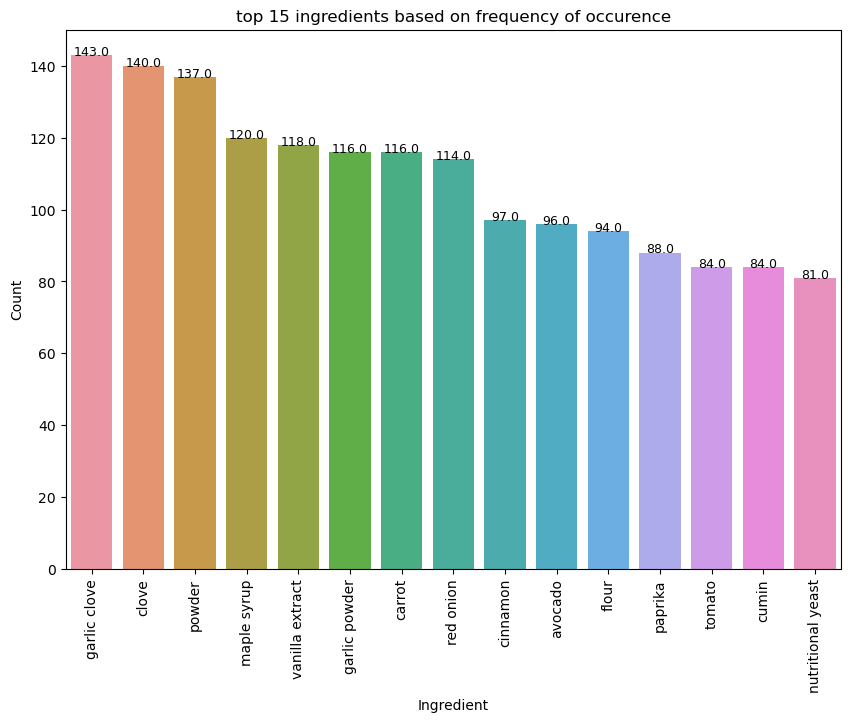

In [32]:
#creating a bar plot with the top ingredients

x= df_top_ingredients['Ingredient']
y= df_top_ingredients['Count']

plt.figure(figsize= (10,7))
ax= sns.barplot(data= df_top_ingredients, x= df_top_ingredients['Ingredient'], y= df_top_ingredients['Count'])
plt.xticks(rotation= 90)
for bar in ax.patches:
    data_values= bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2,  #label positions
            bar.get_y() + bar.get_height(),
            s=f'{data_values}',  #displaying the dynamic labels
            ha='center', #position
            color='black', #color
            size=9) #size
plt.title('top 15 ingredients based on frequency of occurence')
plt.show()

Occurence of garlic colve, onion, paparika can be considered as they are commonly used in many recipes. However maple syrup cominng on top is an interesting finding. If we analyse the top 10, we see alot of flavor additons such as cumin, cinnamon, tomati, vanila extract etc. 

Since this is an analysis on texts, I will use a word cloud to get an overall view as well

(-0.5, 399.5, 199.5, -0.5)

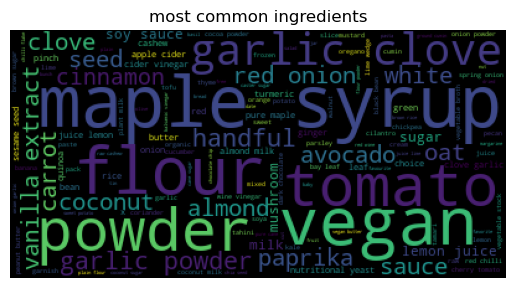

In [33]:
#creating a word cloud with the ingredients

word_cloud_string= ' '
for each_ingredient in combined_ingredient_list:
    word_cloud_string += ' ' + each_ingredient


word_cloud= WordCloud().generate(word_cloud_string)
#plt.figure(figsize=(20,20))
plt.imshow(word_cloud)
plt.title('most common ingredients')
plt.axis('off')

Bottom N

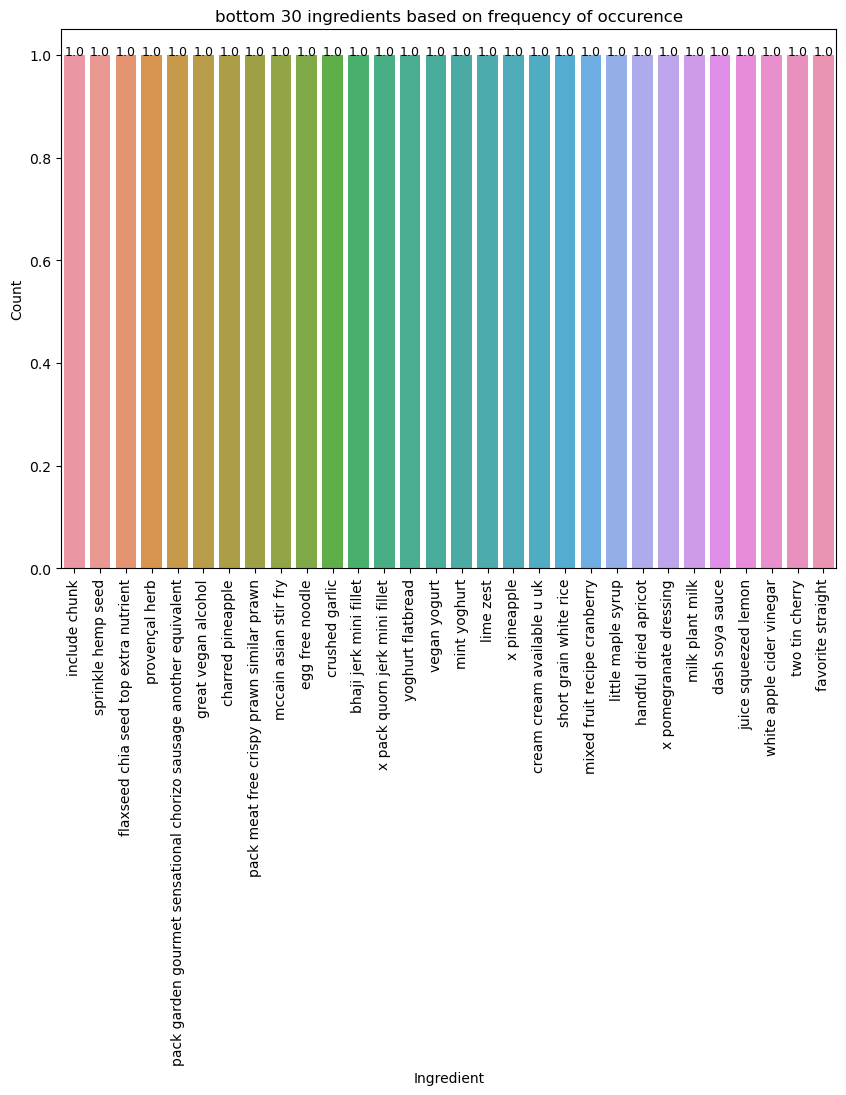

In [34]:
#creating a bar plot with the bottom_n ingredients

x= df_bottom_ingredients['Ingredient']
y= df_bottom_ingredients['Count']

plt.figure(figsize= (10,7))
ax1= sns.barplot(data= df_bottom_ingredients, x= df_bottom_ingredients['Ingredient'], y= df_bottom_ingredients['Count'])
plt.xticks(rotation= 90)
for bar in ax1.patches:
    data_values= bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2,  #label positions
            bar.get_y() + bar.get_height(),
            s=f'{data_values}',  #displaying the dynamic labels
            ha='center', #position
            color='black', #color
            size=9) #size
plt.title('bottom 30 ingredients based on frequency of occurence')
plt.show()

This analysis shows that the least commonly used ingredients are different forms of main ingredients combined with many other words, such as lime zest, chia seeds. This is one disadvantage of not tokenizing them to the nth level. 

I will also now analyse the lengths of ingredients to get an idea of the recipe length.

In [35]:
#getting the length of each cleaned ingredient list

length_of_ingredients= []
for each_ingredient in ingredients_cleaned:
    length_of_ingredients.append(len(each_ingredient.split(',')))
    


In [36]:
#equating the 2 lists 'length_of_ingredients' & 'ingredients cleaned ' to 2 columns 
recipes['length of ingredients']= length_of_ingredients
recipes['ingredients_cleaned']= ingredients_cleaned
recipes.drop(['Unnamed: 0'], axis=1, inplace=True) #dropping the unnamed column 

In [37]:
#creating 2 dataframes with the top n and bottom n length of ingredients
df_length_top= recipes.sort_values(by= 'length of ingredients', ascending=False)
df_length_bottom= recipes.sort_values(by= 'length of ingredients', ascending=True)
df_length_top=df_length_top.head(20)
df_length_bottom= df_length_bottom.head(20)

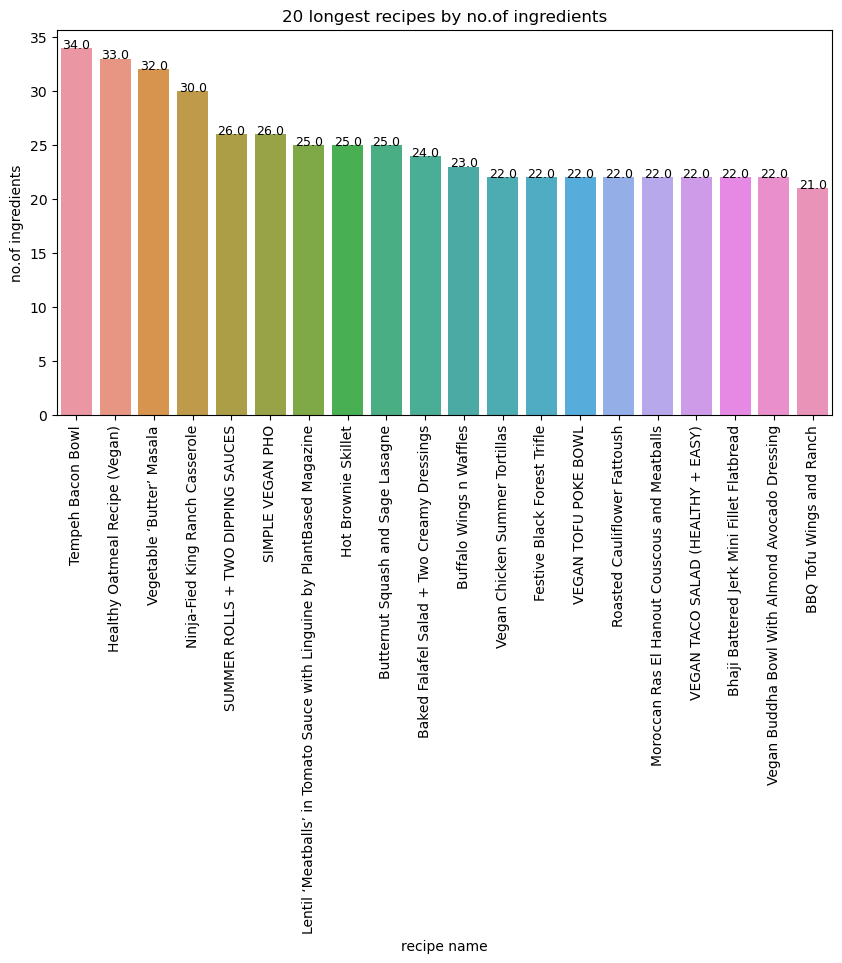

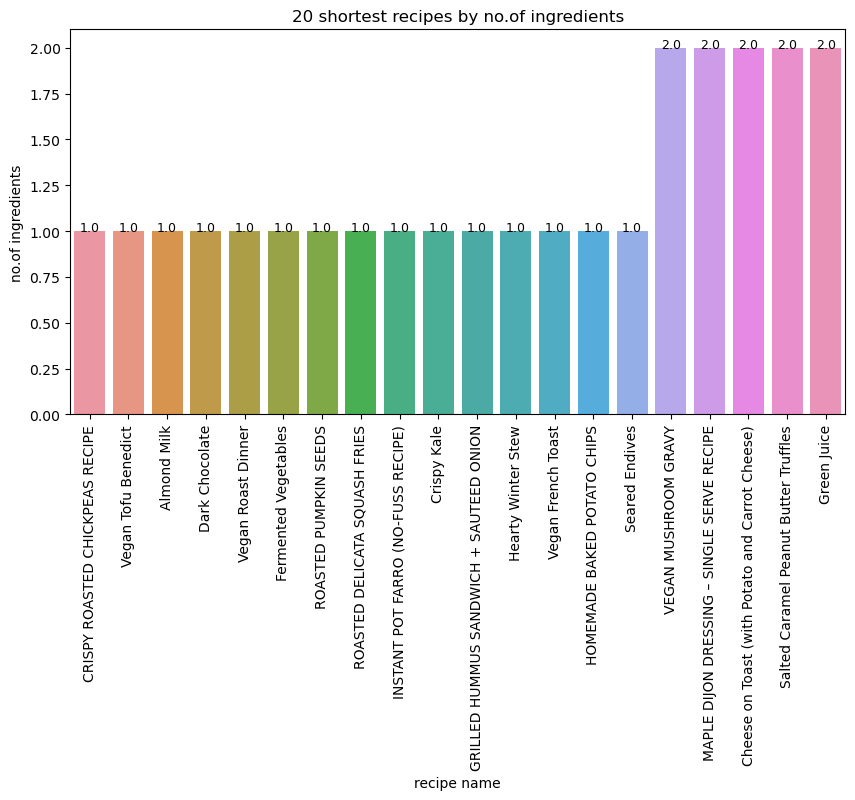

In [38]:
#plotting the graphs with longest and shortest lists of ingredients

#graph 1- longest
x= df_length_top['title'] #defining x
y= df_length_top['length of ingredients'] #defining y

plt.figure(figsize= (10,5))
ax1= sns.barplot(data= df_length_top, x= df_length_top['title'], y= df_length_top['length of ingredients']) #plot
plt.xticks(rotation=90) # xticks
for bar in ax1.patches: #data values
    data_values= bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, 
             bar.get_y() + bar.get_height(), 
             s= f'{data_values}',
             ha= 'center', 
             size= 9)

plt.title('20 longest recipes by no.of ingredients') #title
plt.xlabel('recipe name') #xlabel
plt.ylabel('no.of ingredients') #ylabel
plt.show()

#graph 1- shortest

plt.figure(figsize= (10,5))

x= df_length_bottom['title']
y= df_length_bottom['length of ingredients'] 

ax2= sns.barplot(data= df_length_bottom, x= df_length_bottom['title'], y= df_length_bottom['length of ingredients'])
plt.xticks(rotation=90)
for bar in ax2.patches:
    data_values= bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, 
             bar.get_y() + bar.get_height(), 
             s= f'{data_values}',
             ha= 'center', 
             size= 9)
    
plt.title('20 shortest recipes by no.of ingredients')
plt.xlabel('recipe name')
plt.ylabel('no.of ingredients')
plt.show()

In [39]:
#analysing the length of ingredients column
recipes.describe()

,length of ingredients
count,1382.000000
mean,8.755427
std,4.379643
min,1.000000
25%,6.000000
50%,8.000000
75%,11.000000
max,34.000000


Text(0.5, 1.0, 'distribution of length of ingredients')

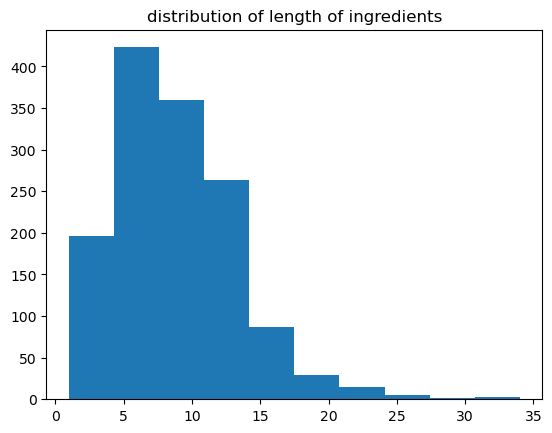

In [40]:
plt.hist(recipes['length of ingredients'])
plt.title('distribution of length of ingredients')

Above further shows that the mean no.of ingredients is ~8.7 and 50% marks at 8 as well. This implies that data lies towards that quadrant as opposed the the max recorded at 34. Most of the recipes fall in the range 5-8 and hence this shows that the databse recipes are generally require limited ingredients. Because of this our similarity could either be very high or even low as many dont need alot of ingredients.

 With above analysis, length of ingredients ranges from 1-34. And there is no visible pattern in the lengths by different recipe types. Recipes with shorter number of ingredients are possibly due to the fact that we removed basic ingredients such as oil, salt, pepper. 

### <a id='toc2_1_4_'></a>[Title column](#toc0_)

#### <a id='toc2_1_4_1_'></a>[Data cleaning](#toc0_)

In [41]:
#defining a variable for the title
title= recipes['title']

Title column needs not much processing for the purpose of the solution. But for anlysis and visualisation, I will use the same function parser developed to remove biases from the data.

In [42]:
#apply the parser
cleaned_title= title.apply(parser)

In [43]:
#cleaned data
cleaned_title

0                                   rainbow rice
1                                          nacho
2                               hazelnut truffle
3                    simple roasted radish chicp
4                                apple charlotte
                          ...                   
1385                    west african peanut stew
1386                        almond flour cracker
1387                      baked vegan mac cheese
1388    southwest chickpea salad creamy dressing
1389              besy vegan mushroom stroganoff
Name: title, Length: 1382, dtype: object

In [44]:
#combined titles 
combined_titles=[]

#for each_title in title:
combined_titles.extend(cleaned_title)

In [45]:
combined_titles


['rainbow rice',
 'nacho',
 'hazelnut truffle',
 'simple roasted radish chicp',
 'apple charlotte',
 'chilli vegetable pizza',
 'choc raspberry porridge',
 '',
 'vegan full english breakfast',
 'garlic herb gournay',
 'tahini protein ball',
 'mexican bean lasagne',
 'avocado toast',
 'thai chickpea burger pak choi',
 'butternut squash sage lasagne',
 'pie',
 'best vegan burger',
 'lemon coriander falafel',
 'lazy lahmacun',
 'superduper superfoods',
 'nutty chocolate truffle',
 'hot cross bun',
 'vegan lunch',
 'lentil bolognese',
 'courgette potato sujebi',
 'chocolate fudge cake',
 'superfood salad',
 'orange ginger cupcake',
 'lemon tart',
 'pumpkin macaroni',
 'chia',
 'chinese tomato stir fry',
 'sundried tomato tapenade',
 'sushi bowl',
 'butter bean shaak gujarati favourite',
 'spanakorizo',
 'choc peanut butter porridge',
 'smoky veggie wellington',
 'tofu edamame stir fry',
 'ultimate hummus supreme sandwich',
 'white miso summer soup wakame saffron',
 'chilli non carne',
 'sw

#### <a id='toc2_1_4_2_'></a>[Exploratary analysis](#toc0_)

I will do a similar word cloud analysis for the titles too to understand the type of recipes in the dataset. 

(-0.5, 399.5, 199.5, -0.5)

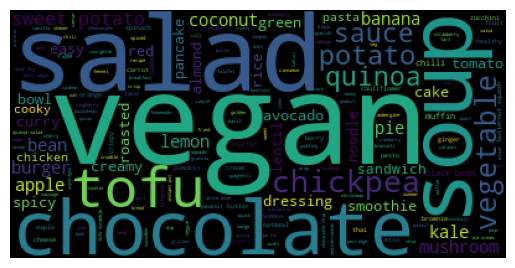

In [46]:
#creating a word cloud for combined title list
title_word_cloud_string= ' '

for each_title in combined_titles:
    title_words= each_title.split() #splitting to individual words
    title_string= ' '.join(title_words) #concatenating the words in each title list to one string
    title_word_cloud_string += ' ' + title_string # converting all titles to one string

title_word_cloud= WordCloud().generate(title_word_cloud_string) #generating the word cloud
plt.imshow(title_word_cloud)
plt.axis('off')

Since word vegan appears in many recipes, it is skewing the data right now. Therefore we will remove it to get a better understanding of the distribution.

In [47]:
title_words_to_remove= ['vegan']


def parser_title(input_keys):
    
    input_list = re.split(',', input_keys) #splitting the ingredients by commas 
    
    cleaned_title = [] #new list to store cleaned ingredients 

    lemmatizer = WordNetLemmatizer() #lemmatizer 

    for each_input in input_list:
        items = re.split(' ', each_input)  #splitting each ingredient by space to process and clean

        items = [word for word in items if word.isalpha()] #filtering only letters 

        tagged_items= pos_tag(items) #tagging the words to identify verbs 

        items= [word for word, pos in tagged_items if not pos.startswith('VB')] #filtering to remove any word which is a verb

        items = [word.lower() for word in items] #lowercasing 

        items = [lemmatizer.lemmatize(word) for word in items] #lemmatizing 

        items = [word for word in items if word not in ENGLISH_STOP_WORDS] #removing stop words

        items = [word for word in items if word not in measuring_words] #removing measuring words 

        items = [word for word in items if word not in words_to_remove] #removing additional words 

        items = [word for word in items if word not in title_words_to_remove] #removing additional words 

        if items:
            cleaned_title.append(' '.join(items) ) #joining the individual words of the ingredient seperated by space 
    cleaned_title= ','.join(cleaned_title) #joining the ingreidents back seprated by commas 


    return cleaned_title


In [48]:
#cleaned titles without the word vegan
titles_cleaned_without_vegan= title.apply(parser_title)
titles_cleaned_without_vegan

0                                   rainbow rice
1                                          nacho
2                               hazelnut truffle
3                    simple roasted radish chicp
4                                apple charlotte
                          ...                   
1385                    west african peanut stew
1386                        almond flour cracker
1387                            baked mac cheese
1388    southwest chickpea salad creamy dressing
1389                    besy mushroom stroganoff
Name: title, Length: 1382, dtype: object

In [49]:
#combined titles 
combined_titles_without_vegan=[]

#for each_title in title:
combined_titles_without_vegan.extend(titles_cleaned_without_vegan)

Text(0.5, 1.0, 'most common words used in the title')

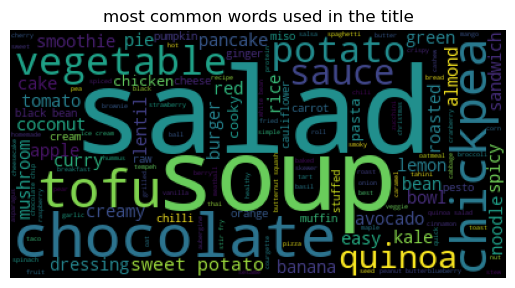

In [50]:
#updated title word plot without the word 'vegan'
title_word_cloud_string_updated= ' '

for each_title in titles_cleaned_without_vegan:
   
    title_words_updated= each_title.split() #splitting to individual words
    title_string_updated= ' '.join(title_words_updated) #concatenating the words in each title list to one string
    title_word_cloud_string_updated += ' ' + title_string_updated # converting all titles to one string

title_word_cloud_updated= WordCloud().generate(title_word_cloud_string_updated) #generating the word cloud
plt.imshow(title_word_cloud_updated)

plt.axis('off')
plt.title('most common words used in the title')
#plt.figure(figsize= (200,300))

In [51]:
#creating a combined title list with the cleaned titles
title_word_counts= []

for each_title in titles_cleaned_without_vegan:
    for word in each_title:
        words= each_title.split() #splitting the title words
        count= Counter(words) #getting the count of words
        title_word_counts.append(count) #adding to the count list

combined_counts= Counter()
for count in title_word_counts:
    combined_counts += count #combining all counts to one list
combined_counts

df_combined_titles= pd.DataFrame(combined_counts.items(), columns=['Recipe type', 'Count']) #dataframe to store the title data
 

We can check the counts of these recipe types too. 

In [52]:
df_combined_titles.sort_values(by='Count', ascending=False).head(20) #checking the most common titile words 

,Recipe type,Count
66,salad,3668
53,chocolate,2393
61,potato,1962
99,soup,1942
31,bean,1756
90,tofu,1607
170,sweet,1532
36,chickpea,1468
339,quinoa,1416
214,sauce,1409


In [53]:
df_combined_titles.sort_values(by='Count', ascending=True).head(20) #checking the least common title words 

,Recipe type,Count
412,game,4
313,nori,4
1028,naan,4
657,palak,5
57,lunch,5
1068,queso,5
1069,aioli,5
516,cooler,6
1001,pozole,6
824,eggnog,6


This shows that some of the most common recipe types are;
- Soup
- Salad
- Chocolate
- Tofu based
- Chickpea based
- Burger
- Quinona based etc


This gives a good idea when we develop the solution to expect these type of results more, however a deep clustering could analyse this further.

I will now also check the length of recipe titiles to see if there are any patterns. For that I will get the length of the words in the titles.

In [54]:
#title length
length_of_titles= []
for each_title in titles_cleaned_without_vegan:
    length_of_titles.append(len(each_title.split(' ')))

In [55]:
#adding the columns to the dataset
recipes['title_cleaned']=cleaned_title
recipes['length_of_titles']=length_of_titles

In [56]:
recipes.head()


,href,title,ingredients,preparation,length of ingredients,ingredients_cleaned,title_cleaned,length_of_titles
0,https://veganuary.com/recipes/rainbow-rice/,Rainbow Rice,"Carrot ribbons (just use a peeler for speed),F...","Cook the rice as instructed on the packaging.,...",8,"carrot ribbon peeler,frozen pea,red cabbage,re...",rainbow rice,2
1,https://veganuary.com/recipes/mfc-nachos/,Nachos,"400g Meatless Farm Co mince (or similar),400g ...","Preheat the oven to 350ºF,Heat the oil in a la...",4,"meatless farm co mince,refried bean,tomato pur...",nacho,1
2,https://veganuary.com/recipes/hazelnut-truffles/,Hazelnut Truffles,"100g hazelnuts,2 tablespoons + 1 tablespoon ca...","Preheat the oven to 200c,Put the hazelnuts in ...",3,"hazelnut,cacao,almond",hazelnut truffle,2
3,https://veganuary.com/recipes/simple-roasted-r...,Simple Roasted Radish by ChicP,"1 170g tub beetroot and horseradish houmous,30...","Pre heat the oven to 160°C,Cut the radishes in...",2,"tub beetroot horseradish houmous,mixed radish",simple roasted radish chicp,4
4,https://veganuary.com/recipes/baked-apple-char...,Baked Apple Charlotte,"2 tbsp rapeseed oil,75g pitted dates,450g bram...","Serves 9,You will need an 8inch/23cm square ba...",4,"date,gluten free flour,dairy free milk almond ...",apple charlotte,2


Text(0.5, 1.0, 'distribution of length of titles')

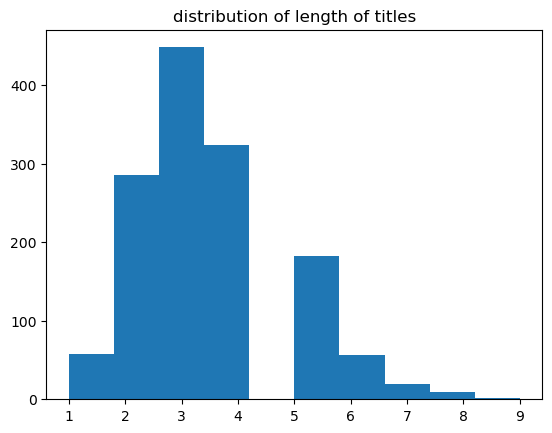

In [57]:
#plotting the histogram
plt.hist(recipes['length_of_titles'])
plt.title('distribution of length of titles')

This is a distribution where we can see the title lengths vary from 1-8 and most of them are centraised in the 3-4 range. It is also interesting to see that 4-5 range has none. Now I will check another step to see if there is any correlation between the lnegth of ingredients and titles. 

/var/folders/0y/k2wtvzs527g8z6726scfz6_80000gn/T/ipykernel_1132/3461216144.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix= recipes.corr()


<Axes: >

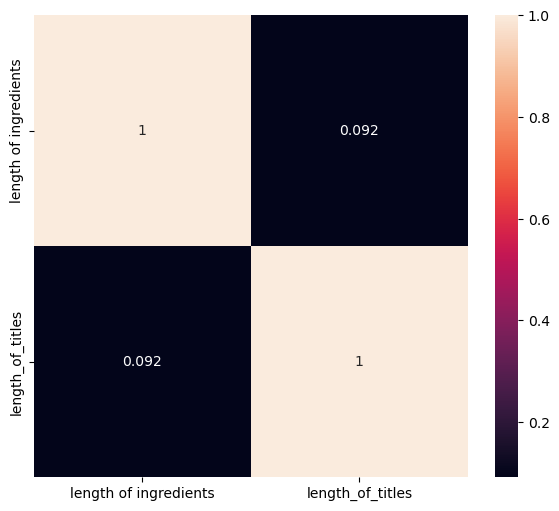

In [58]:
plt.figure(figsize=(7,6))
corr_matrix= recipes.corr()
sns.heatmap(corr_matrix, annot=True)

In [59]:
recipes.describe()

,length of ingredients,length_of_titles
count,1382.000000,1382.000000
mean,8.755427,3.425470
std,4.379643,1.318235
min,1.000000,1.000000
25%,6.000000,3.000000
50%,8.000000,3.000000
75%,11.000000,4.000000
max,34.000000,9.000000


This now gives an overall view of the lengths of the two columns, ingredients and title.

# <a id='toc3_'></a>[Modeling](#toc0_)

### <a id='toc3_1_1_'></a>[Word2vec](#toc0_)

Since this is a text analysis, I will use Word2vec which will enable creating embeddings for each word which then can be  converted to a vector for further analysis. I will use a sample of my data to do the modeling.

In [60]:
#taking 75% of the data for modeling
sample_recipes = recipes.sample(frac=.75, random_state=99)
sample_recipes.head()

,href,title,ingredients,preparation,length of ingredients,ingredients_cleaned,title_cleaned,length_of_titles
1014,https://simple-veganista.com/sweet-potato-blac...,Sweet Potato Black Bean Chili,"Units,USM ,Scale,1x2x3x ,1 tablespoon olive oi...",",Instructions,Saute: In a large pot or dutch o...",14,"garlic clove,powder,cumin,oregano,garlic onion...",sweet potato black bean chili,5
534,https://veganuary.com/recipes/rainbow-smoothie/,Rainbow Smoothie,"2 tbsp of chia seeds,3/4 cup of coconut or any...",First you will have to create each layer. Do i...,10,"chia seed,coconut plant milk,mango,oat,raw cac...",rainbow smoothie,2
254,https://veganuary.com/recipes/raspberry-martin...,Raspberry Martini Cocktail,"35ml Moose Spirit,35ml Raspberry Puree/ juice,...",1. Add all ingredients in to a cocktail shaker...,7,"moose spirit,raspberry juice,framboise,lime ju...",raspberry martini cocktail,3
865,https://simple-veganista.com/diy-edible-sugar-...,Glow Sugar Scrub (DIY Sugar Body Scrub),"Units,USM ,Scale,1x2x3x ,Base,1 cup sugar of c...",",Instructions,Mix: Place sugar in a small/medi...",7,"base,sugar choice pure cane,brown pure cane,tu...",glow sugar scrub sugar body,5
1134,https://simple-veganista.com/roasted-delicata-...,ROASTED DELICATA SQUASH + CRANBERRY SALAD,"Scale,1x2x3x ,2 small delicata squash,1 1/2 cu...",",Instructions,Preheat oven to 400 degrees F.,S...",12,"pecan,maple syrup,dash cinnamon,red onion,baby...",roasted delicata squash cranberry salad,5


In [61]:
sample_recipes=sample_recipes.drop(['ingredients_cleaned'], axis=1)

In [62]:
#applying the parser
ingredients_sample= sample_recipes['ingredients_cleaned']= sample_recipes['ingredients'].apply(parser)

I read up that getting a consistent order on the corpus is important in Word2vec as it predicts words based on the surrounding, therefore I will sort all ingredients by the alphabetical order to maintain consistency.

In [63]:
# get corpus with the documents sorted in alphabetical order

data = sample_recipes

data['ingredients_cleaned'] = data.ingredients.apply(parser) #parse the ingredients

def get_and_sort_corpus(data):
   
    corpus_sorted = []

    for doc in data.ingredients_cleaned.values:

        doc= doc.split(',') #split by comma
        doc.sort() #sort
        sorted_doc= ','.join(doc) #join by comma
        corpus_sorted.append(sorted_doc) #append the sorted doc
        
    
    return corpus_sorted #sorted corpus
  
# calculate average length of each document 

def get_window(corpus):

    lengths = [len(doc) for doc in corpus]
    avg_len = float(sum(lengths)) / len(lengths)
    
    return round(avg_len)



corpus = get_and_sort_corpus(data) #corpus

print(f"Length of corpus: {len(corpus)}")


Length of corpus: 1036


In [64]:
#tokenizing the words to input them for the modeling
tokenized_ingredients = ingredients_sample.apply(lambda x: word_tokenize(x.lower()))  

model_1=Word2Vec(sentences=tokenized_ingredients,min_count=1, sg=0, window=get_window(corpus), workers=8) #word2vec model, used min_count=1 to avoid any ingredient being missed out

print(model_1.wv.most_similar(u'onion', topn=5)) #checking the most similar results for onion


[('red', 0.9998520612716675), ('clove', 0.9997941851615906), ('garlic', 0.9997685551643372), ('black', 0.9997490048408508), ('tomato', 0.9997314214706421)]


Tokenizing to individual words give similar results which dont make sense such as 'red', 'bell' which ideally should be combined with another word. Hence I will use the phrases model to train the model to find frequently used words together. I initially wanted to find the best hyperparameters for the word2vec model, but couldn't find literature on the process. Hence used the average.

In [65]:
tokenized_corpus = [word_tokenize(document.lower()) for document in corpus]

phrases_tokenizer= Phrases(tokenized_corpus, min_count=1, threshold=1) #phrases model

tokenized_phrases_ingredients = [phrases_tokenizer[document] for document in tokenized_corpus] #tokenized phrases

phrases_model = Word2Vec(

tokenized_phrases_ingredients, sg=0, workers=8, window=get_window(corpus), min_count=1, vector_size=100) #word2vec model, sg=0 to get CBOW, window= average length of the corups, min_count=1 to avoid any ingr. missing out 

embeddings= {word: phrases_model.wv[word] for word in phrases_model.wv.index_to_key} 

tokenized_ingredients = ingredients_sample.apply(lambda x: word_tokenize(x.lower())) 

phrases_tokenizer= Phrases(corpus, min_count=1, threshold=1) #phrases moel

tokenized_phrases_ingredients= tokenized_ingredients.apply(lambda x: phrases_tokenizer[x]) #tokenized phrases

phrases_model = Word2Vec(

corpus, sg=0, workers=8, window=10, min_count=1, vector_size=100)

phrases_model.save('phrases_model.bin')

embeddings= {word: phrases_model.wv[word] for word in phrases_model.wv.index_to_key} #creating embeddings for each output 

In [66]:
print(phrases_model.wv.most_similar(u'onion', topn=5)) #again checkin the most similar words to onion

[('carrot', 0.9999294281005859), ('seed', 0.9999205470085144), ('leaf', 0.9999191164970398), ('avocado', 0.9999187588691711), ('sauce', 0.9999173879623413)]


Now the results make more sense !!

In [67]:
phrases_model.wv.most_similar('potato', topn=10) #checking for tofu

[('green', 0.9998742938041687),
 ('carrot', 0.9998711943626404),
 ('bean', 0.9998704195022583),
 ('sauce', 0.9998688697814941),
 ('leaf', 0.9998636841773987),
 ('red_onion', 0.9998595118522644),
 ('clove', 0.9998589158058167),
 ('tomato', 0.9998586773872375),
 ('mushroom', 0.9998582005500793),
 ('vegan', 0.9998577833175659)]

I will try to use a tile map to show the similarity of a few ingredients 

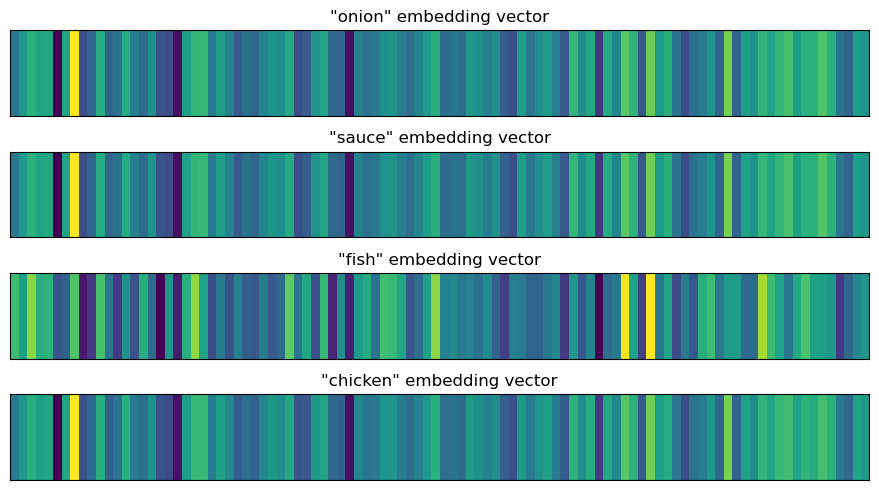

In [68]:
word_list = ['onion', 'sauce', 'fish', 'chicken'] #example

plt.subplots(len(word_list), 1, figsize=(20, 5)) #plot

for i, word in enumerate(word_list): #for loop to get each word in the list
    plt.subplot(len(word_list), 1, i + 1) #subplot
    plt.imshow(np.tile(embeddings[word], (10, 1))) #data
    plt.xticks([]) #no xticks
    plt.yticks([]) #no yticks
    plt.title(f"\"{word}\" embedding vector") #title

plt.tight_layout()
plt.show()

It is visible that words such as onion, sauce, chicken show similar distribution where as fish  is  different, which is right.Lets see why chicken shows similar behavior

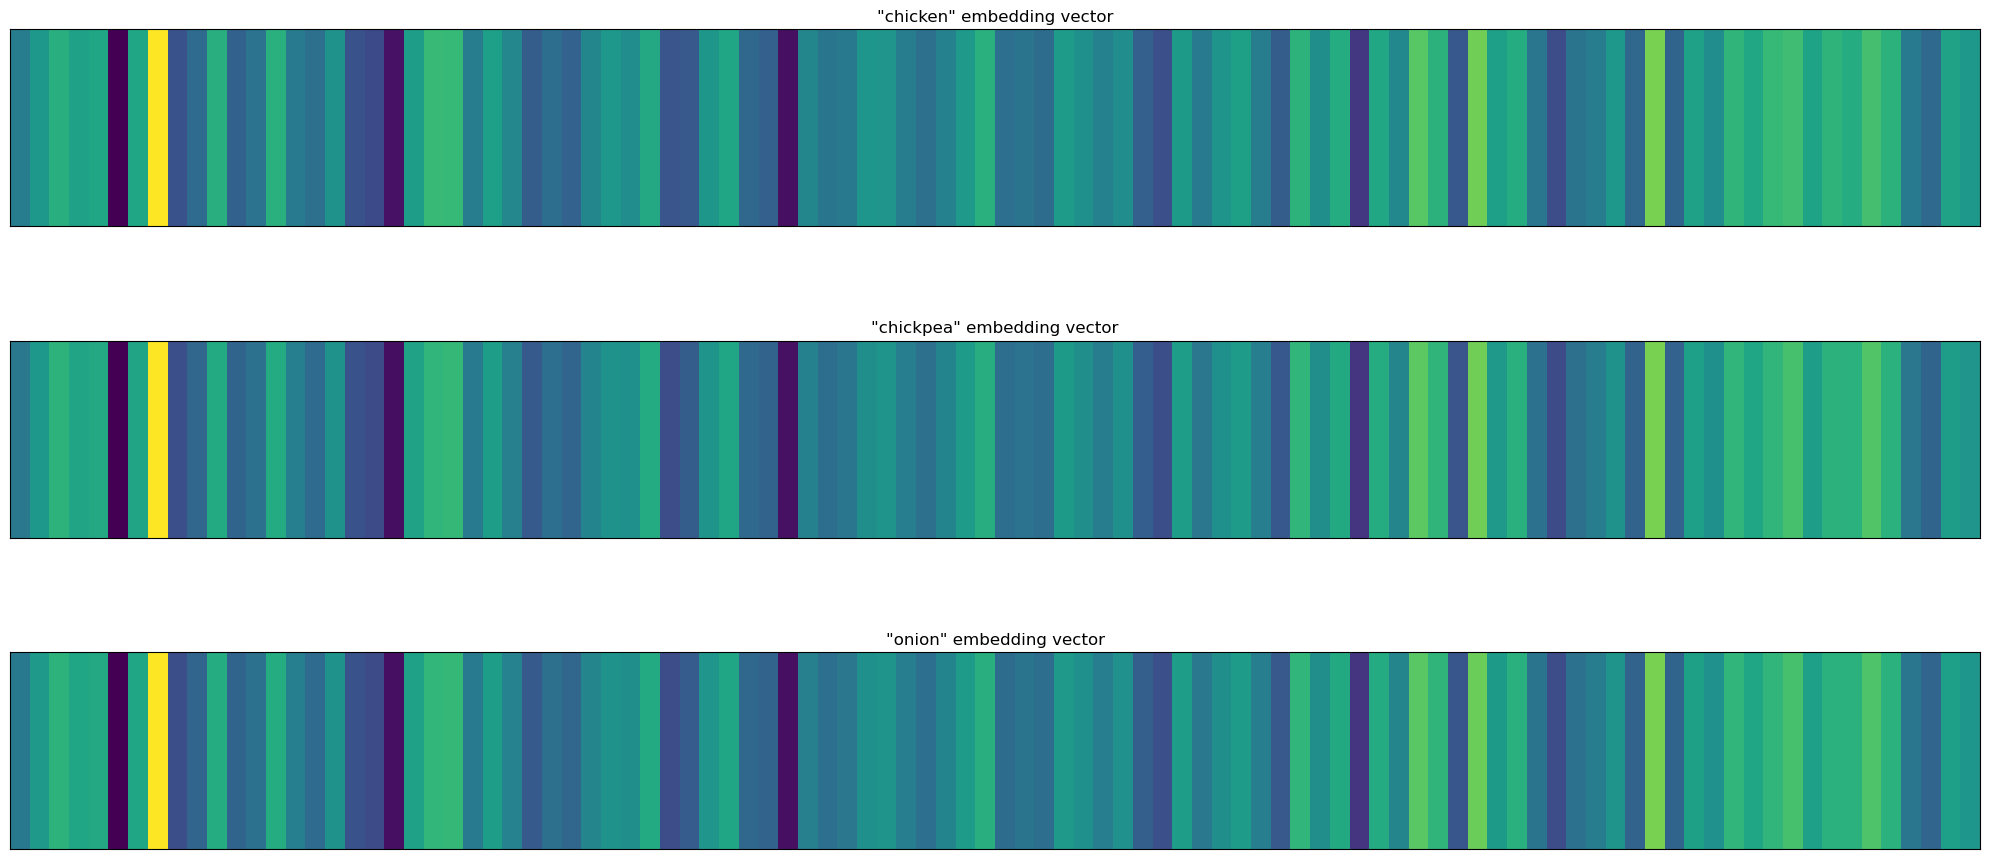

In [69]:
word_list = ['chicken', 'chickpea', 'onion'] #example

plt.subplots(len(word_list), 1, figsize=(20, 10)) #plot

for i, word in enumerate(word_list): #for loop to get each word in the list
    plt.subplot(len(word_list), 1, i + 1) #subplot
    plt.imshow(np.tile(embeddings[word], (10, 1))) #data
    plt.xticks([]) #no xticks
    plt.yticks([]) #no yticks
    plt.title(f"\"{word}\" embedding vector") #title

plt.tight_layout()
plt.show()

Seems like chicken is following the behavior of other non meat items.

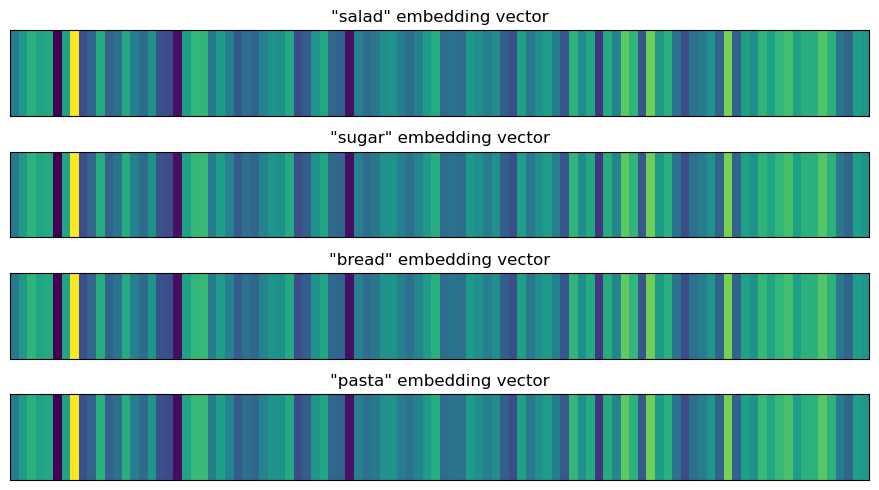

In [70]:
word_list = ['salad', 'sugar', 'bread', 'pasta'] #example

plt.subplots(len(word_list), 1, figsize=(20, 5)) #plot

for i, word in enumerate(word_list): #for loop to get each word in the list
    plt.subplot(len(word_list), 1, i + 1) #subplot
    plt.imshow(np.tile(embeddings[word], (10, 1))) #data
    plt.xticks([]) #no xticks
    plt.yticks([]) #no yticks
    plt.title(f"\"{word}\" embedding vector") #title

plt.tight_layout()
plt.show()

Testing with more ingredients, it is noted that the graph looks quite similar, indicating an issue in the model or the data processing. Or the dataset itself. 

In [71]:
#saving the model
phrases_model.save('/Users/anupajayakody/BrainStation/CAPSTONE/CAPSTONE_GITHUB/Capstone/Models/phrases_model.bin')

#### <a id='toc3_1_1_1_'></a>[Mean Embedding Vector](#toc0_)

Next, I will start creating the fucntions to get the Mean Vector for each embedding. I will create two functions, one with the simple average of the embedding and the 2nd with the TFIDF vectorization. 

In [72]:
#mean word vectors class

class MeanEmbeddingVector(object): 

    def __init__(self, phrases_model): 
        
        """
         
        input : phrases model
        output: average embeddings for each ingredient list

        """
        

        self.phrases_model= phrases_model #model
        self.vector_size= phrases_model.wv.vector_size #vector size

        

    def fit(self): #fit

        return self
    

    def transform(self, docs): #transforming the docs

        doc_word_vector= self.word_average_list(docs)

        
        return doc_word_vector
    
    

    def word_average(self, doc): #function to get the average embedding for one ingredient list

        mean= []

        for word in doc: #for each ingredient 

            if word in self.phrases_model.wv.index_to_key: #if ingredient is in the vocabulary
                mean.append(self.phrases_model.wv.get_vector(word)) #get the mean for the word
        
        if not mean: #if not mean, return zeros to the size of the model vectors
            return np.zeros(self.vector_size)
        
        else: #if mean yes, get the mean across the axis =0
            mean= np.array(mean).mean(axis=0)

            return mean #return mean
        
        
    def word_average_list (self, docs): #function to get the average embeddings for the total list of ingredients 

            return np.vstack((self.word_average(doc) for doc in docs)) #stacking the individual word averages for each ingredient in the list

#### <a id='toc3_1_1_2_'></a>[TFIDF Embedding Vectoriser](#toc0_)

I will also create a TFIDF Mean Vectoriser as it would help to get kore context on the words than just the occurence counts. TFIDF will identify the importance of an ingredient in the context of the total list of ingredients.

In [73]:
#mean word vectors class

class TFIDFMeanEmbeddingVector(object): 

    def __init__(self, phrases_model): 
        
        """
         
        input : phrases model
        output: average embeddings for each ingredient list

        """
        

        self.phrases_model= phrases_model #model
        self.word_idf_weight= None
        self.vector_size= phrases_model.wv.vector_size #vector size

        

    def fit(self, docs): #fit


        text_docs= []

        for doc in docs:
            text_docs.append(' '. join(doc))   #append using space
        
        tfidf= TfidfVectorizer()
        
        tfidf.fit(text_docs) #fitting

        max_idf= max(tfidf.idf_) #max idf definition,  if a word was never seen it is given idf of the max of known idf value

        #self.word_idf_weight= defaultdict(
         #                                   lambda : max_idf, [(word, tfidf[i])  for word, i in tfidf.vocabulary_.items()])
        
        self.word_idf_weight = defaultdict(lambda: max_idf, tfidf.vocabulary_)


        return self
    

    def transform(self, docs): #transforming the docs

        doc_word_vector= self.doc_average_list(docs)
        
        return doc_word_vector
    

    def doc_average(self, doc): #function to get the average embedding for one ingredient list

        mean= []

        for word in doc: #for each ingredient 

            if word in self.phrases_model.wv.index_to_key: #if ingredient is in the vocabulary
                mean.append(self.phrases_model.wv.get_vector(word) * self.word_idf_weight[word]) #get the mean for the word
        
        if not mean: #if not mean, return zeros to the size of the model vectors
            return np.zeros(self.vector_size)
        
        else: #if mean <> empty, get the mean across the axis =0
            mean= np.array(mean).mean(axis=0)

            return mean #return mean
        
        
    def doc_average_list (self, docs): #function to get the average embeddings for the total list of ingredients 

            return np.vstack((self.doc_average(doc) for doc in docs)) #stacking the individual word averages for each ingredient in the list

### <a id='toc3_1_2_'></a>[Recommendations](#toc0_)

Next step is to get these mean word vectors and create the recommendations. I will create a function to give the recoomendations based on the N defined, input ingredients and the cosine similarity between the input and the ingredients in recipes

In [74]:
def get_recommendations (N, score): 
     
     """
     
     Top recommendations, 
      
        input :  N, cosine similiarity scores 
        output : top N recommendations in a dataframe with title, ingredients, score 
     
     """
     
     top_recipes= sorted(range(len(score)), key=lambda i : score[i], reverse= True) [:N] #sorting the recipes by the score, getting the N results 
     
     recommendation= pd.DataFrame( columns=['title','ingredients', 'score'] ) #dataframe with columns
     
     count= 0
     
     for i in top_recipes: #defining the data for each recommendation

        recommendation.at[count, 'title']= recipes['title'][i]
        recommendation.at[count, 'ingredients']= recipes['ingredients'][i]
        recommendation.at[count, 'score']= f"{score[i]}"

        count += 1 #for count + 1 th row
        
        
     return recommendation #recommendation dataframe 



def recommendation_working (input_ingredients, N=5, mean= False):

    """ 
    
    fucntion to calculate the recommendations

        input : input ingredients seperated by commas, tuple
        N: 5
        output: recommendations dataframe
    
    """

    model= Word2Vec.load("/Users/anupajayakody/BrainStation/CAPSTONE/CAPSTONE_GITHUB/Capstone/Models/phrases_model.bin") #loading the saved model

    model.wv.init_sims() #normalizing the embeddings 

    data= sample_recipes #getting the recipe data

    data['ingredients_cleaned']= data['ingredients'].apply(parser) #applying the parser

    corpus= get_and_sort_corpus(data)


    if mean:
        mean_vectors= MeanEmbeddingVector(model) #getting the averages for all words
    
        doc_vec= mean_vectors.transform(corpus) #getting the doc_vec for ingredients
    
        doc_vec = [doc.reshape(1, -1) for doc in doc_vec] #reshape 
        
   
    else :
        
        tfidf_vector= TFIDFMeanEmbeddingVector(model) #tfidf for all words
        
        tfidf_vector.fit(tokenized_phrases_ingredients) #fit
        
        doc_vec= tfidf_vector.transform(data['ingredients_cleaned']) #transform
        
        doc_vec = [doc.reshape(1, -1) for doc in doc_vec] #reshape 


    #user input mapping

    input= input_ingredients #input ingredients

    formatted_input = ','.join(map(str, input)) #converting to str, mapping and joining by the ','
    
    input= parser(formatted_input) #apply the parser to clean

    if mean:

        input_embedding= mean_vectors.transform([input])[0].reshape(1,-1) #getting the average embdeddings for the input giving the shape of 1, 

    else : 

        input_embedding= tfidf_vector.transform([input])[0].reshape(1,-1) #getting the TFIDF average embdeddings for the input giving the shape of 1,

    
    cosine_sim= map(lambda x: cosine_similarity(input_embedding.reshape(1,-1), x.reshape(1,-1))[0][0], doc_vec) #cosine sim. between the input and the doc of vectors 
    
    
    score= list(cosine_sim) #listing scores

    recommendations= get_recommendations(N, score) #claculating using the get_recommendation function

    return recommendations #return recommendations 



We will test the model and see the results.

In [75]:
input_ingredients= 'tofu', 'onion', 'chickpea'

recommendation_working(input_ingredients)


/var/folders/0y/k2wtvzs527g8z6726scfz6_80000gn/T/ipykernel_1132/2334212518.py:45: DeprecationWarning: Call to deprecated `init_sims` (Use fill_norms() instead. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.wv.init_sims() #normalizing the embeddings
/var/folders/0y/k2wtvzs527g8z6726scfz6_80000gn/T/ipykernel_1132/1685982210.py:71: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.vstack((self.doc_average(doc) for doc in docs)) #stacking the individual word averages for each ingredient in the list


,title,ingredients,score
0,"Peanut Butter, Maple Syrup ‘Nice’ Cream","6 bananas, frozen,2 tbsp peanut butter/almond ...",0.9999999999999999
1,"KALE, DATE & ALMOND SALAD + LEMON DRESSING","Scale,1x2x3x ,juice of 1 large lemon,1 teaspoo...",0.9999999999999996
2,Cherry Bakewell Baked Oats,"80g Porridge oats,2 tbsp. Ground flaxseed,20g ...",0.9999999999999991
3,Bombay Chilli and Lentil Vegan Cheese Toastie,"1 tsp Chaat Masala or Garam Masala,½ red peppe...",0.9999999999999987
4,Perfect Potato Salad,"750g small potatoes,1 bunch of spring onions,6...",0.9999999999999984


In [76]:
input_ingredients= 'tofu'

recommendation_working(input_ingredients)

/var/folders/0y/k2wtvzs527g8z6726scfz6_80000gn/T/ipykernel_1132/2334212518.py:45: DeprecationWarning: Call to deprecated `init_sims` (Use fill_norms() instead. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.wv.init_sims() #normalizing the embeddings
/var/folders/0y/k2wtvzs527g8z6726scfz6_80000gn/T/ipykernel_1132/1685982210.py:71: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.vstack((self.doc_average(doc) for doc in docs)) #stacking the individual word averages for each ingredient in the list


,title,ingredients,score
0,Tarka Dal,"For the Dal:,3 Tbsp vegetable oil,1 onion, fin...",1.0
1,NO BAKE CHOCOLATE PISTACHIO COOKIE BALLS,"Scale,1x2x3x ,3/4 cup medjool dates (about 7 –...",0.9999999999999996
2,Chilli Tomato & Basil Baked Beans on Toast,"1 red onion, diced,2 cans of mixed beans (or a...",0.9999999999999991
3,French Toast,Brine/aquafaba from one can of cannellini/navy...,0.9999993116969691
4,Omnipork’s Omni Wellington,"Omni log,• 400g OmniPork Mince,• 100g OmniPork...",0.9999993116809726


In [77]:
input_ingredients= 'fish'

recommendation_working(input_ingredients)

/var/folders/0y/k2wtvzs527g8z6726scfz6_80000gn/T/ipykernel_1132/2334212518.py:45: DeprecationWarning: Call to deprecated `init_sims` (Use fill_norms() instead. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.wv.init_sims() #normalizing the embeddings
/var/folders/0y/k2wtvzs527g8z6726scfz6_80000gn/T/ipykernel_1132/1685982210.py:71: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.vstack((self.doc_average(doc) for doc in docs)) #stacking the individual word averages for each ingredient in the list


,title,ingredients,score
0,Maple Cinnamon Granola,"3 cups of rolled oats,1/2 cup of almonds (roug...",1.0
1,Katsu Curry,Half a medium butternut squash OR 1 large aube...,0.9999989645737676
2,Berry and Banana Muffins,"275g gluten/wheat free plain flour,1 tablespoo...",0.9999986952438109
3,Santa Fe Black Bean Burger (Vegan),"Scale,1x2x3x ,1 can (14 oz) organic black bean...",0.9999985063099264
4,Vegan ‘Chicken’ Salad,"Scale,1x2x3x ,3 cups cooked or 2 cans (15 oz) ...",0.9999980700758464


In [78]:
phrases_model.wv.most_similar('fish', topn=10) #checking for fish

[('combo', 0.6730202436447144),
 ('mocha', 0.6685635447502136),
 ('veg', 0.6672291159629822),
 ('veggie_stick', 0.6652721762657166),
 ('frond', 0.6633143424987793),
 ('bhaji', 0.663210928440094),
 ('saffron_strand', 0.6627355217933655),
 ('nākd_cocoa', 0.6625533699989319),
 ('black_pitted', 0.66237473487854),
 ('kind', 0.6622640490531921)]

In [79]:
phrases_model.wv.most_similar('chicken', topn=10) #checking for chicken

[('favourite', 0.9975322484970093),
 ('tomato_puree', 0.997527539730072),
 ('pumpkin_seed', 0.9975232481956482),
 ('chia_seed', 0.9975175261497498),
 ('basmati_rice', 0.9974878430366516),
 ('paste', 0.9974851012229919),
 ('onion', 0.9974845051765442),
 ('ground_cumin', 0.9974731802940369),
 ('caster_sugar', 0.9974721074104309),
 ('noodle', 0.99745774269104)]

Conclusion at this stage is the the cosine similarity is quite high indicating that the model is overfitted. I need to further analyse. Example when I get the similar words for fish, the results that come makes sense as it doesnt have any non-veg recipes, but when I get the recommendations, the results show a high similarity.